# Anomaly Detection in Time Series
This notebook demonstrates how to detect anomalies in time series data using:

- Z-Score Analysis
- SARIMAX Residual Analysis
- Isolation Forest

We will use a synthetic dataset with injected anomalies.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

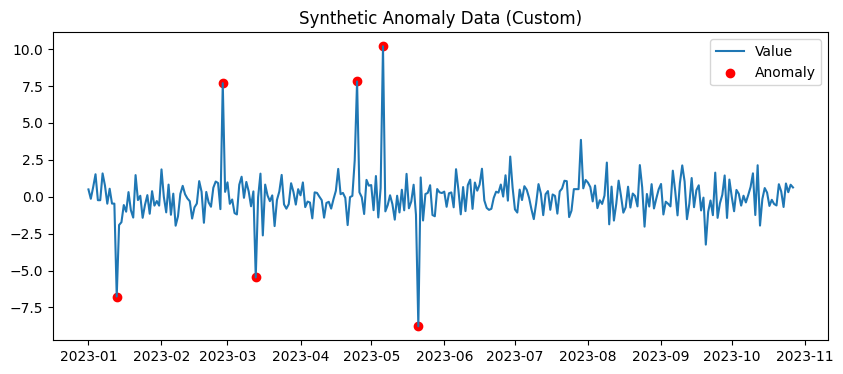

In [3]:
np.random.seed(42)  # For reproducibility
random.seed(42)
# Time range
dates = pd.date_range(start='2023-01-01', periods=300, freq='D')

# Normal baseline
data = np.random.normal(loc=0.0, scale=1.0, size=len(dates))

# Inject anomalies at random locations
anomaly_indices = random.sample(range(300), 6)
for idx in anomaly_indices:
    data[idx] += np.random.choice([8, -9, 10, -7])  # Spike/drop

# Create DataFrame
df = pd.DataFrame({'date': dates, 'value': data})
df['is_anomaly'] = False
df.loc[anomaly_indices, 'is_anomaly'] = True

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['is_anomaly'], 'date'], df.loc[df['is_anomaly'], 'value'], color='red', label='Anomaly')
plt.legend()
plt.title('Synthetic Anomaly Data (Custom)')
plt.show()


## Z-Score Analysis
We calculate the z-score to detect values that are statistically distant from the mean.

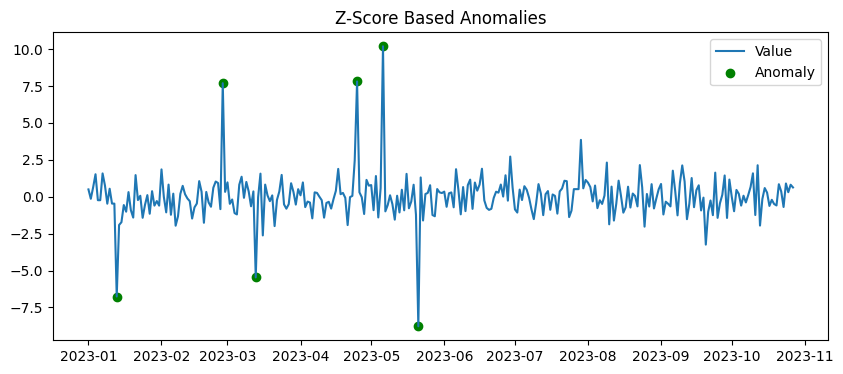

In [4]:
df['z_score'] = zscore(df['value'])
df['z_anomaly'] = df['z_score'].apply(lambda x: abs(x) > 3)

# Visualise
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['z_anomaly'], 'date'], df.loc[df['z_anomaly'], 'value'], color='green', label='Anomaly')
plt.title('Z-Score Based Anomalies')
plt.legend()
plt.show()

## SARIMAX Residual Analysis
We fit a SARIMAX model and use residuals to detect anomalies. Large residuals suggest unexpected behaviour.

c:\Users\sread\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sread\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


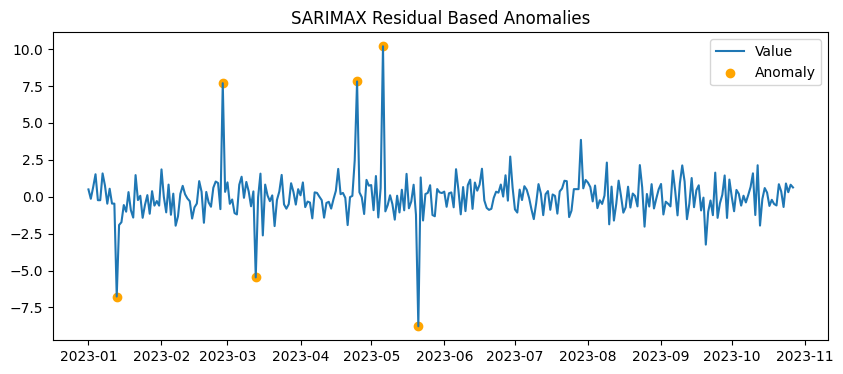

In [14]:
model = SARIMAX(df['value'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)
df['residuals'] = results.resid
threshold = 3 * np.std(df['residuals'])
df['sarimax_anomaly'] = abs(df['residuals']) > threshold

# Visualise
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['sarimax_anomaly'], 'date'], df.loc[df['sarimax_anomaly'], 'value'], color='orange', label='Anomaly')
plt.title('SARIMAX Residual Based Anomalies')
plt.legend()
plt.show()

## Isolation Forest
Isolation Forest is a machine learning model that isolates anomalies based on how easy they are to separate.

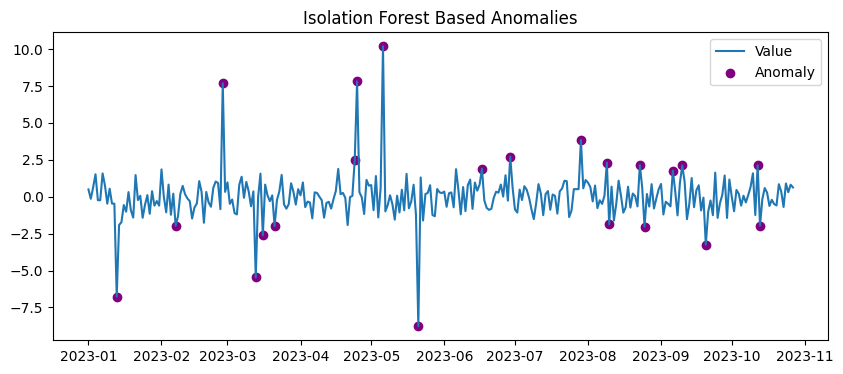

In [ ]:
iso_forest = IsolationForest(contamination='0.05', random_state=42)
df['iso_score'] = iso_forest.fit_predict(df[['value']])
df['iso_anomaly'] = df['iso_score'] == -1

# Visualise
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['iso_anomaly'], 'date'], df.loc[df['iso_anomaly'], 'value'], color='purple', label='Anomaly')
plt.title('Isolation Forest Based Anomalies')
plt.legend()
plt.show()